# DATA

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
from google.colab import drive


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/labeled.csv')


In [7]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


# **preprocess**

In [ ]:
!pip list

In [9]:
from tensorflow.keras.layers import TextVectorization

In [10]:
# Предполагая, что `comment` это ваш текстовый столбец, и `toxic` - целевая переменная
X = df['comment']  # Используйте 'comment_text' если ваш столбец так называется
y = df['toxic'].values.reshape(-1, 1)  # Преобразуем y в правильную форму, если это бинарная классификация

In [11]:
MAX_FEATURES = 200000  # Максимальное количество слов в словаре
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int')

vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(len(df))  # Используйте размер вашего датасета для параметра shuffle
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)  # Помогает уменьшить время ожидания при обучении

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer adjusted for binary classification
model.add(Dense(1, activation='sigmoid'))  # Изменено для бинарной классификации


In [22]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])  # Использование binary_crossentropy
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

In [23]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
630/630 [==============================] - 1050s 2s/step - loss: 0.4264 - accuracy: 0.7995 - val_loss: 0.1758 - val_accuracy: 0.9347
Epoch 2/5
630/630 [==============================] - 1056s 2s/step - loss: 0.1891 - accuracy: 0.9301 - val_loss: 0.0808 - val_accuracy: 0.9760
Epoch 3/5
630/630 [==============================] - 1066s 2s/step - loss: 0.0854 - accuracy: 0.9717 - val_loss: 0.0568 - val_accuracy: 0.9840
Epoch 4/5
630/630 [==============================] - 1067s 2s/step - loss: 0.0478 - accuracy: 0.9868 - val_loss: 0.0313 - val_accuracy: 0.9917
Epoch 5/5
630/630 [==============================] - 1065s 2s/step - loss: 0.0318 - accuracy: 0.9927 - val_loss: 0.0230 - val_accuracy: 0.9934


<Figure size 800x500 with 0 Axes>

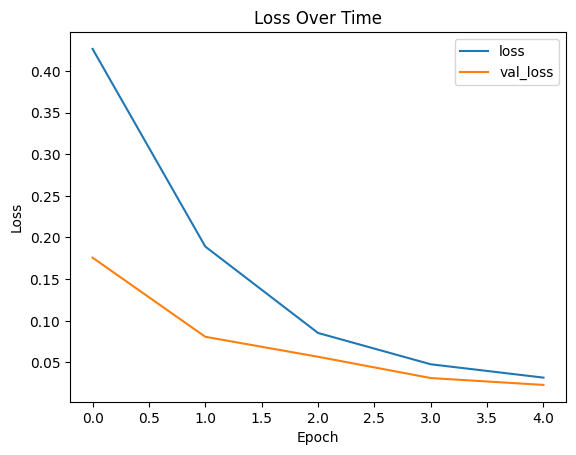

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Построение графиков функции потерь и точности
plt.figure(figsize=(8, 5))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()  # График функции потерь
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()


<Figure size 800x500 with 0 Axes>

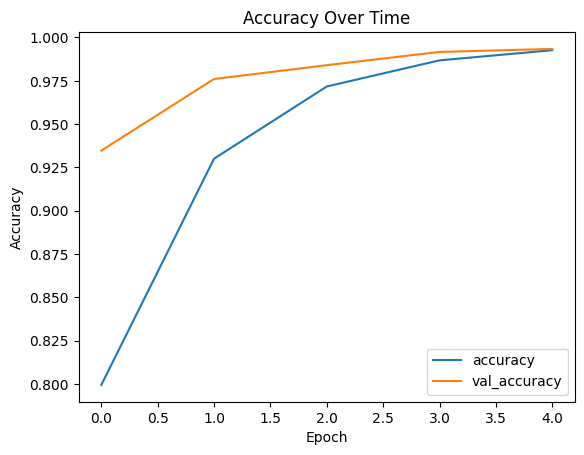

In [25]:
plt.figure(figsize=(8, 5))
history_df[['accuracy', 'val_accuracy']].plot()  # График точности
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.show()

# Make Predictions

In [26]:
input_text = vectorizer('Ты меня так бесишь! Я собираюсь тебя ударить.')

In [27]:
batch = test.as_numpy_iterator().next()

In [28]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([128,  42,  18, ...,   0,   0,   0])>

In [29]:
model.predict(np.array([input_text]))

1/1 [==============================] - 2s 2s/step


array([[0.12935218]], dtype=float32)

In [30]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 128ms/step


In [31]:
(res > 0.5).astype(int)

array([[0]])

In [32]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [33]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 180ms/step


array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [34]:
res.shape

(1, 1)

# `Evaluate Model`

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [37]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 182ms/step


In [38]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9959349632263184, Recall:0.9919028282165527, Accuracy:0.23333333432674408


# Test

In [39]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=

In [40]:
import tensorflow as tf
import gradio as gr

In [41]:
model.save('toxicity.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
import gradio as gr

def score_comment(comment):
    vectorized_comment = vectorizer([comment])  # Убедитесь, что vectorizer инициализирован
    prediction = model.predict(vectorized_comment)
    is_toxic = prediction[0][0] > 0.5
    return "Токсичность: Да" if is_toxic else "Токсичность: Нет"


In [54]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder="Введите комментарий для оценки"),
                         outputs=gr.Text())

In [55]:
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d2affb6aa0a5262c99.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
